In [1]:
import os
import tensorflow as tf
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import load_model
from tensorflow.keras import layers, models
from loss import custom_loss

from loss import *
from models import *
from OptimizedDataGenerator import OptimizedDataGenerator

pi = 3.14159265359

maxval=1e9
minval=1e-9

2024-12-03 02:13:07.443741: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-03 02:13:07.443810: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-03 02:13:07.445302: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 02:13:08.630093: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-03 02:13:34.474797: W tensorflow/compiler/tf2

In [2]:
fingerprint = 'fd7d2433'
model = CreateModel((13,21,2), n_filters=5, pool_size=3)

base_dir = f'./trained_models/model-{fingerprint}-checkpoints'
checkpoint_files = [os.path.join(base_dir, f) for f in os.listdir(base_dir) if f.endswith('.hdf5')]
latest_checkpoint = max(checkpoint_files, key=os.path.getmtime)
training_cp_path = os.path.join(base_dir, 'training_log.csv')
training_history = pd.read_csv(training_cp_path)

print(f"Loading model from {latest_checkpoint}")
model.load_weights(latest_checkpoint)

2024-12-03 02:14:40.441496: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38410 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB MIG 7g.40gb, pci bus id: 0000:21:00.0, compute capability: 8.0
2024-12-03 02:14:40.718953: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Loading model from ./trained_models/model-fd7d2433-checkpoints/weights.73-t-24672.26-v-24864.27.hdf5


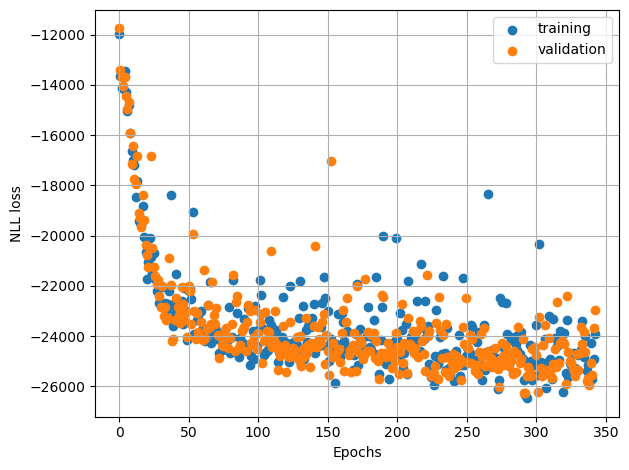

In [3]:
plt.scatter(training_history['epoch'], training_history['loss'])
plt.scatter(training_history['epoch'], training_history['val_loss'])
plt.legend(['training', 'validation'])
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('NLL loss')
plt.tight_layout() 

plt.savefig(os.path.join(base_dir,'training_hist.png'))
plt.show()

In [4]:
print(training_history.to_string())


     epoch          loss  loss_eq_l1_constraint      loss_obj      val_loss
0        0 -11979.707031               0.075518 -11979.782227 -11752.306641
1        1 -13652.000977               0.136696 -13652.137695 -13411.651367
2        2 -14126.786133               0.192961 -14126.979492 -13686.074219
3        3 -14137.030273               0.247479 -14137.277344 -14058.480469
4        4 -13427.211914               0.303225 -13427.515625 -13700.239258
5        5 -14295.375977               0.361531 -14295.737305 -14435.016602
6        6 -15027.725586               0.427098 -15028.152344 -14939.434570
7        7 -14804.974609               0.496334 -14805.470703 -14696.130859
8        8 -15910.354492               0.555853 -15910.910156 -15917.541992
9        9 -16629.601562               0.612900 -16630.214844 -17149.371094
10      10 -16983.730469               0.677521 -16984.408203 -16427.675781
11      11 -17188.087891               0.740002 -17188.828125 -17738.966797
12      12 -

In [5]:
tfrecords_dir_val = "/depot/cms/users/das214/tfrecords_2t_val_d8"
test_generator = OptimizedDataGenerator(
    load_from_tfrecords_dir = tfrecords_dir_val,
)

In [6]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 13, 21, 2)]       0         
                                                                 
 q_separable_conv2d (QSepar  (None, 11, 19, 5)         33        
 ableConv2D)                                                     
                                                                 
 q_activation (QActivation)  (None, 11, 19, 5)         0         
                                                                 
 q_conv2d (QConv2D)          (None, 11, 19, 5)         30        
                                                                 
 q_activation_1 (QActivatio  (None, 11, 19, 5)         0         
 n)                                                              
                                                                 
 average_pooling2d (Average  (None, 3, 6, 5)           0     

In [7]:
# predicts test data
p_test = model.predict(test_generator)

 4/59 [=>............................] - ETA: 2s  

2024-12-03 02:15:25.761931: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907


59/59 [==============================] - 10s 158ms/step


In [8]:
complete_truth = None
for _, y in tqdm(test_generator):
        if complete_truth is None:
            complete_truth = y
        else:
            complete_truth = np.concatenate((complete_truth, y), axis=0)

100%|██████████| 59/59 [00:03<00:00, 15.63it/s]


In [9]:
# creates df with all predicted values and matrix elements - 4 predictions, all 10 unique matrix elements
df = pd.DataFrame(p_test,columns=['x','M11','y','M22','cotA','M33','cotB','M44','M21','M31','M32','M41','M42','M43'])

# stores all true values in same matrix as xtrue, ytrue, etc.
df['xtrue'] = complete_truth[:,0]
df['ytrue'] = complete_truth[:,1]
df['cotAtrue'] = complete_truth[:,2]
df['cotBtrue'] = complete_truth[:,3]
df['M11'] = minval+tf.math.maximum(df['M11'], 0)
df['M22'] = minval+tf.math.maximum(df['M22'], 0)
df['M33'] = minval+tf.math.maximum(df['M33'], 0)
df['M44'] = minval+tf.math.maximum(df['M44'], 0)

df['sigmax'] = abs(df['M11'])
df['sigmay'] = np.sqrt(df['M21']**2 + df['M22']**2)
df['sigmacotA'] = np.sqrt(df['M31']**2+df['M32']**2+df['M33']**2)
df['sigmacotB'] = np.sqrt(df['M41']**2+df['M42']**2+df['M43']**2+df['M44']**2)

# calculates residuals for x, y, cotA, cotB
residuals = df['xtrue'] - df['x']
residualsy = df['ytrue'] - df['y']
residualsA = df['cotAtrue'] - df['cotA']
residualsB = df['cotBtrue'] - df['cotB']

# stores results as csv
df.to_csv("test_4x4.csv",header=True,index=False)

# residuals (mean, stdv)

In [10]:
# x
(np.mean(residuals)*75,np.std(residuals)*75)

(-0.557410775218159, 8.6946627125144)

In [11]:
# y
(np.mean(residualsy)*18.75,np.std(residualsy)*18.75)

(-0.17427679267711937, 2.0785517524927855)

In [12]:
# cotA
(np.mean(residualsA)*8,np.std(residualsA)*8)

(-0.03490222245454788, 0.23382693529129028)

In [13]:
# cotB
(np.mean(residualsB)*0.5,np.std(residualsB)*0.5)

(0.0028547390829771757, 0.057285819202661514)

# x residuals

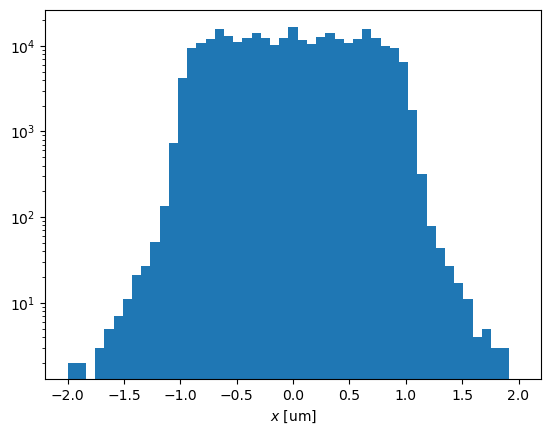

In [14]:
plt.hist(p_test[:,0],bins=np.linspace(-2,2,50))
plt.yscale('log')
plt.xlabel(r'$x$ [um]')

save_fig_path = os.path.join(base_dir, 'x_dist.png')
plt.savefig(save_fig_path)

plt.show()

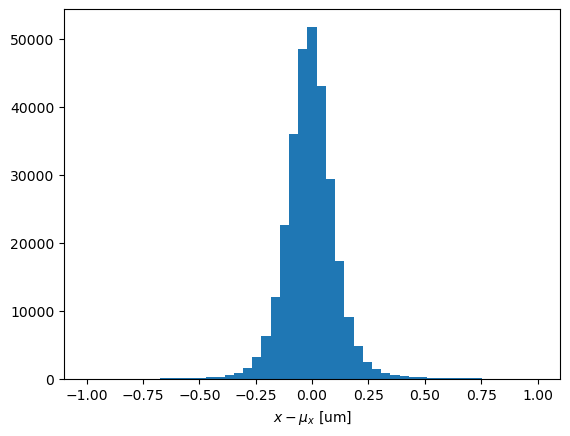

In [15]:
plt.hist(residuals,bins=np.linspace(-1,1,50))
#plt.yscale('Log')
plt.xlabel(r'$x-\mu_x$ [um]')

save_fig_path = os.path.join(base_dir, 'x_res_dist.png')
plt.savefig(save_fig_path)

plt.show()

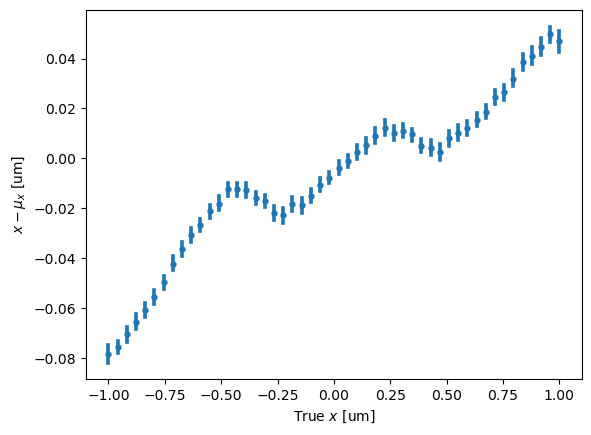

In [16]:
x = sns.regplot(x=df['xtrue'], y=(df['xtrue']-df['x']), x_bins=np.linspace(-1,1,50), fit_reg=None, marker='.')
plt.xlabel(r'True $x$ [um]')
plt.ylabel(r'$x-\mu_x$ [um]')

save_fig_path = os.path.join(base_dir, 'x_vs_res.png')
plt.savefig(save_fig_path)

plt.show()

# y residuals

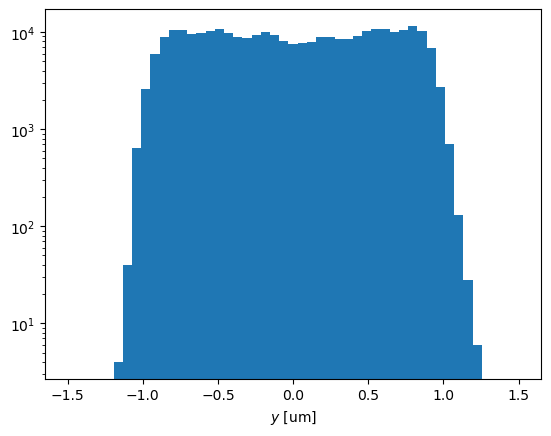

In [17]:
plt.hist(p_test[:,2],bins=np.linspace(-1.5,1.5,50))
plt.yscale('log')
plt.xlabel(r'$y$ [um]')

save_fig_path = os.path.join(base_dir, 'y_dist.png')
plt.savefig(save_fig_path)

plt.show()

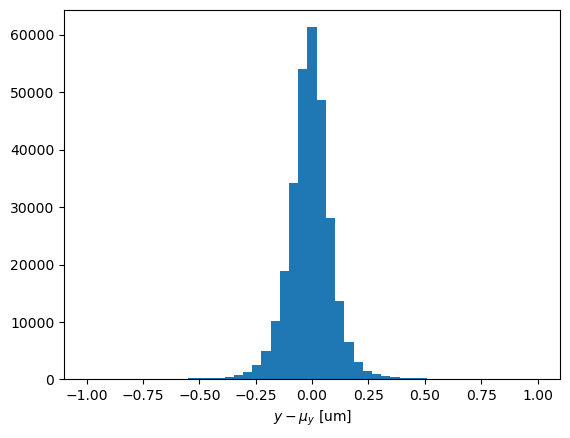

In [18]:
plt.hist(residualsy,bins=np.linspace(-1,1,50))
#plt.yscale('Log')
plt.xlabel(r'$y-\mu_y$ [um]')

save_fig_path = os.path.join(base_dir, 'y_res_dist.png')
plt.savefig(save_fig_path)

plt.show()

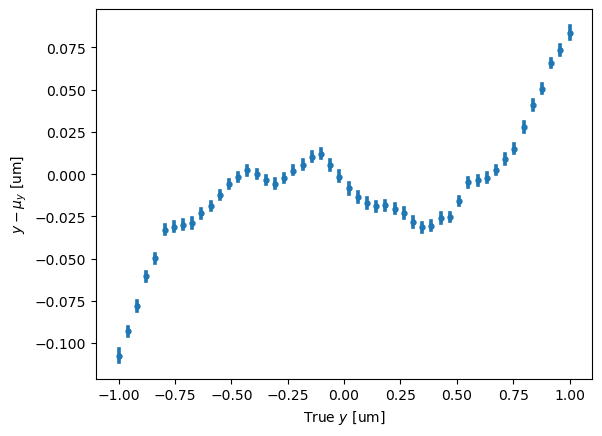

In [19]:
x = sns.regplot(x=df['ytrue'], y=(df['ytrue']-df['y']), x_bins=np.linspace(-1,1,50), fit_reg=None, marker='.')
plt.xlabel(r'True $y$ [um]')
plt.ylabel(r'$y-\mu_y$ [um]')

save_fig_path = os.path.join(base_dir, 'x_vs_res.png')
plt.savefig(save_fig_path)

plt.show()

# cotA residuals

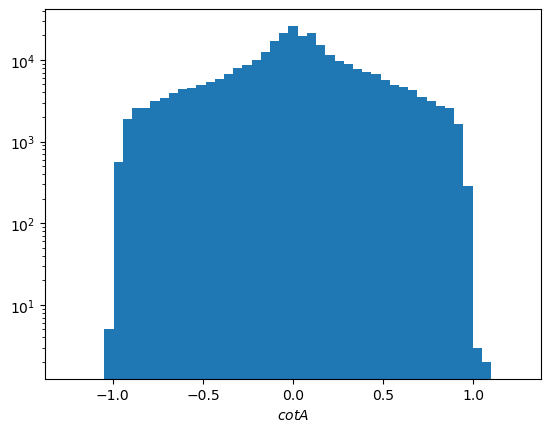

In [20]:
plt.hist(p_test[:,4],bins=np.linspace(-1.25,1.25,50))
plt.yscale('log')
plt.xlabel(r'$cotA$')

save_fig_path = os.path.join(base_dir, 'cotA_dist.png')
plt.savefig(save_fig_path)

plt.show()

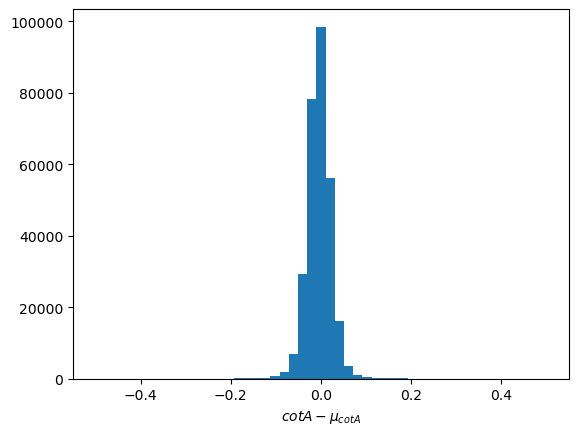

In [21]:
plt.hist(residualsA,bins=np.linspace(-0.5,0.5,50))
#plt.yscale('Log')
plt.xlabel(r'$cotA-\mu_{cotA}$')

save_fig_path = os.path.join(base_dir, 'cotA_res_dist.png')
plt.savefig(save_fig_path)

plt.show()

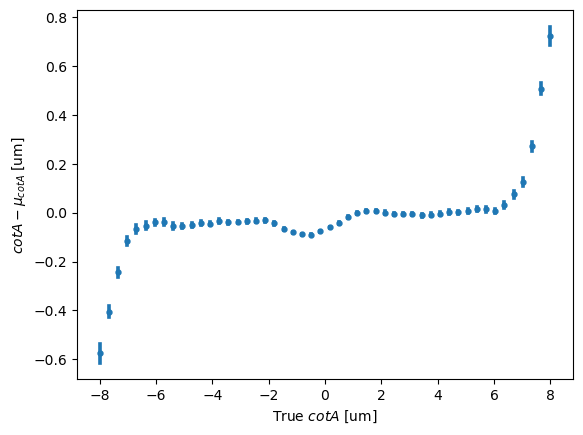

In [22]:
x = sns.regplot(x=df['cotAtrue']*8, y=(df['cotAtrue']-df['cotA'])*8, x_bins=np.linspace(-8,8,50), fit_reg=None, marker='.')
plt.xlabel(r'True $cotA$ [um]')
plt.ylabel(r'$cotA-\mu_{cotA}$ [um]')

save_fig_path = os.path.join(base_dir, 'cotA_vs_res.png')
plt.savefig(save_fig_path)

plt.show()

# cotB residuals

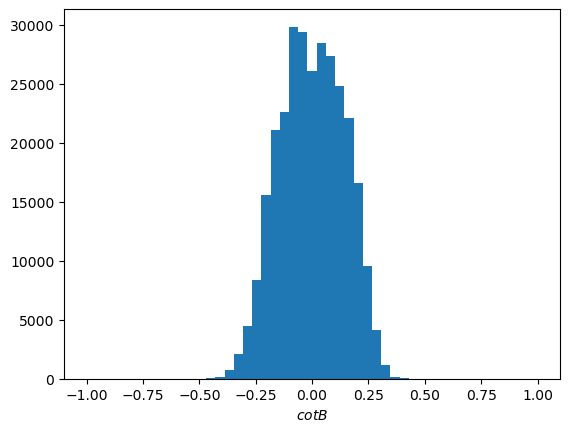

In [23]:
plt.hist(p_test[:,6]*0.5,bins=np.linspace(-1,1,50))
#plt.yscale('Log')
plt.xlabel(r'$cotB$')

save_fig_path = os.path.join(base_dir, 'cotB_dist.png')
plt.savefig(save_fig_path)

plt.show()

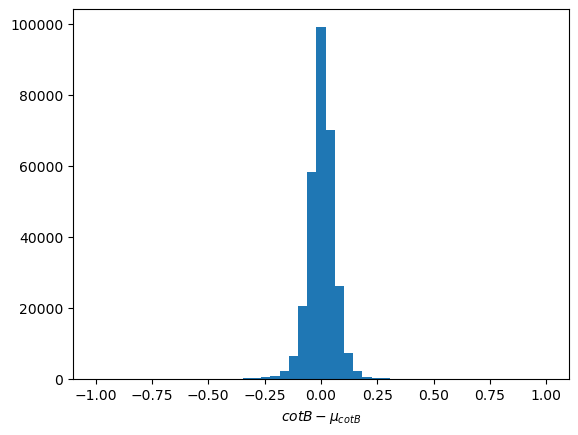

In [24]:
plt.hist(residualsB*0.5,bins=np.linspace(-1,1,50))
#plt.yscale('Log')
plt.xlabel(r'$cotB-\mu_{cotB}$')

save_fig_path = os.path.join(base_dir, 'cotB_res_dist.png')
plt.savefig(save_fig_path)

plt.show()

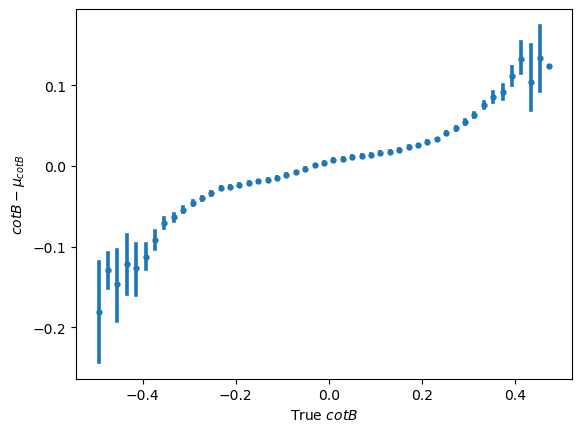

In [25]:
x = sns.regplot(x=df['cotBtrue']*0.5, y=(df['cotBtrue']-df['cotB'])*0.5, x_bins=np.linspace(-1,1,100), fit_reg=None, marker='.')
plt.xlabel(r'True $cotB$')
plt.ylabel(r'$cotB-\mu_{cotB} $')

save_fig_path = os.path.join(base_dir, 'cotB_vs_res.png')
plt.savefig(save_fig_path)

plt.show()

# pull

In [26]:
df['pullx'] = (df['xtrue']-df['x'])/df['sigmax']
df['pully'] = (df['ytrue']-df['y'])/df['sigmay']
df['pullcotA'] = (df['cotAtrue']-df['cotA'])/df['sigmacotA']
df['pullcotB'] = (df['cotBtrue']-df['cotB'])/df['sigmacotB']

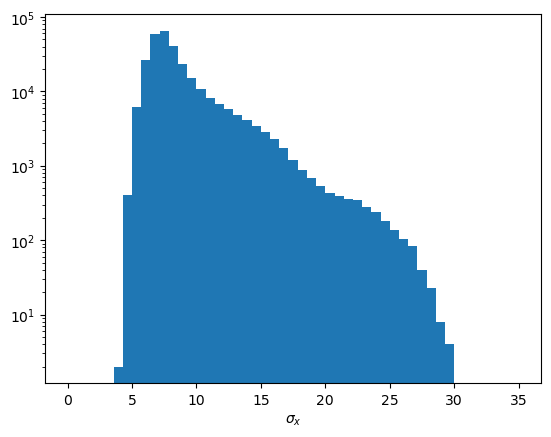

In [27]:
plt.hist(df['sigmax'] * 75,bins=np.linspace(0,35,50))
plt.xlabel('$\sigma_{x}$')
plt.yscale('log')

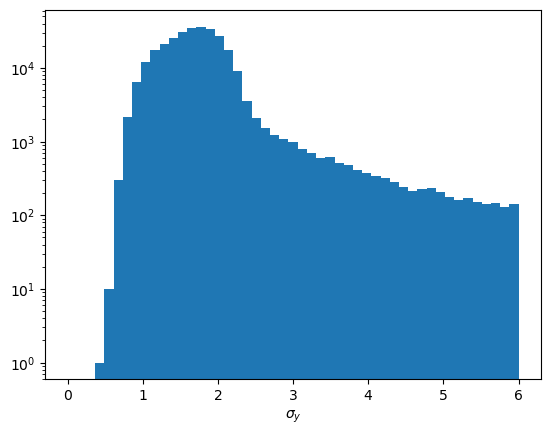

In [28]:
plt.hist(df['sigmay']* 18.75,bins=np.linspace(0,6,50))
plt.xlabel('$\sigma_{y}$')
plt.yscale('log')

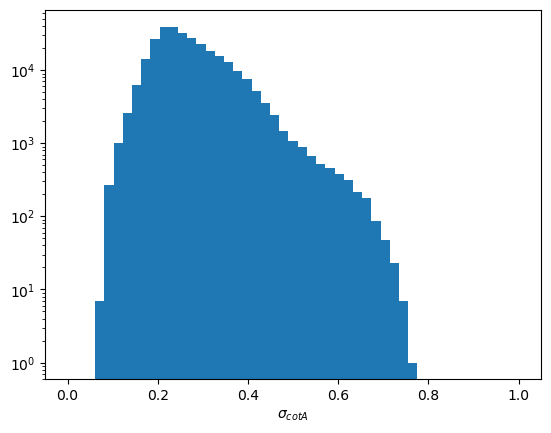

In [29]:
plt.hist(df['sigmacotA'] * 8,bins=np.linspace(0,1.0,50))
plt.xlabel('$\sigma_{cotA}$')
plt.yscale('log')

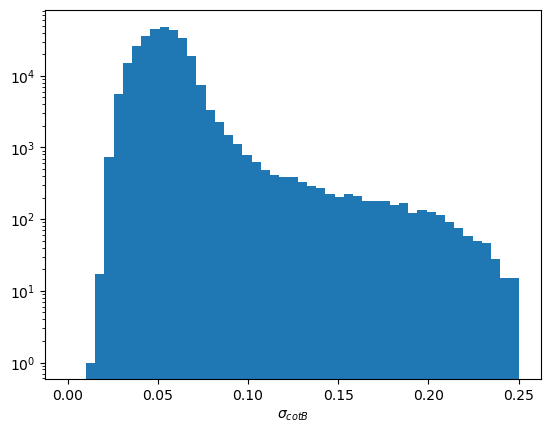

In [30]:
plt.hist(df['sigmacotB'] * 0.5 ,bins=np.linspace(0,0.25,50))
plt.xlabel('$\sigma_{cotB}$')
plt.yscale('log')

In [31]:
from scipy.optimize import curve_fit

def gauss(x, A, mu, sigma):
    return A * np.exp(-(x - mu) ** 2 / (2 * sigma ** 2))

def pull_plot(ax, var, name):
    
    h = ax.hist(df[var],bins=np.linspace(-5,5,50),histtype='step')
    ax.set_xlabel(name)
    ax.set_yscale('log')

    ydata = h[0]
    xdata = h[1][:-1]+3/50.

    pars, cov = curve_fit(gauss,xdata,ydata)

    xbins = np.linspace(-5,5,100)
    ax.plot(xbins,gauss(xbins,pars[0],pars[1],pars[2]),color='black')
    ax.set_ylim(0.5,100000)

    print('Mean',pars[1])
    print('Sigma',pars[2])
    
    ax.text(-5,2000,"$\mu$="+str(round(pars[1],2)))
    ax.text(-5,1000,"$\sigma$="+str(round(abs(pars[2]),2)))

Mean -0.12761479835064957
Sigma -0.8508829374732781
Mean -0.13388835396520846
Sigma 0.9002240565961418
Mean -0.17089320763912233
Sigma 0.7058281152691969
Mean 0.04655285769861826
Sigma -0.9142771356563723


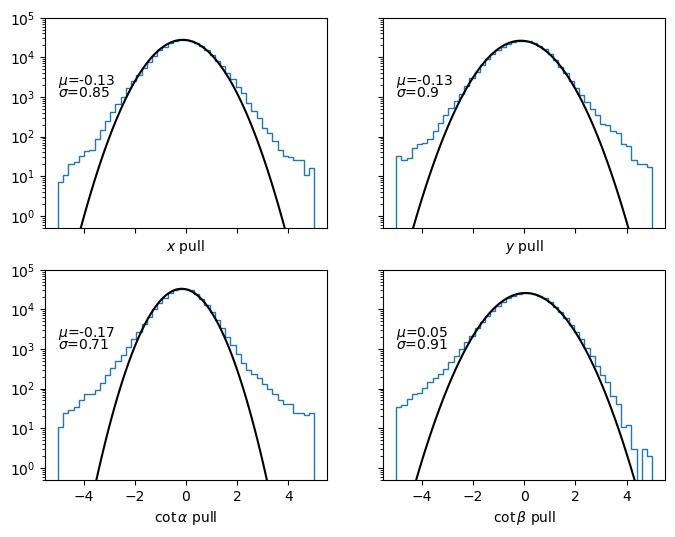

In [32]:
fig, axes = plt.subplots(2,2,sharex=True,sharey=True,figsize=(8,6))
pull_plot(axes[0][0],'pullx',r'$x$ pull')
pull_plot(axes[0][1],'pully',r'$y$ pull')
pull_plot(axes[1][0],'pullcotA',r'$\cot\alpha$ pull')
pull_plot(axes[1][1],'pullcotB',r'$\cot\beta$ pull')

save_fig_path = os.path.join(base_dir, 'Pull.png')
plt.savefig(save_fig_path)

plt.show()

In [33]:
epsilon = 1e-1
target_sparsity = 0.5
scale = 1.0
damping = 1.0

In [34]:
def residual_plot(ax, thisdf, var1, var2, name, scaling=1.0):
    
    nbins = 15
    
    var1_scaled = thisdf[var1] * scaling
    var2_scaled = thisdf[var2] * scaling
    residual_scaled = var1_scaled - var2_scaled
    
    xmin = np.min(var1_scaled)
    xmax = np.max(var1_scaled)
    
    step = 1.0*(xmax-xmin)/nbins
    
    x = sns.regplot(x=var1_scaled, y=residual_scaled, x_bins=np.linspace(xmin,xmax,nbins), fit_reg=None, marker='.', ax=ax)
    ax.set_xlabel('True ' + name)
    ax.set_ylabel('True - predicted ' + name)
    
    thisdf['residual'+var2] = residual_scaled
    print(var1)
    
    means = []
    upbar = []
    downbar = []
    for i in range(0,nbins):
        means += [np.mean(thisdf['residual'+var2][(var1_scaled>xmin + i*step) & (var1_scaled<xmin + (i+1)*step)])]
        upbar += [means[i] + np.mean(thisdf['sigma'+var2][(var1_scaled>xmin + i*step) & (var1_scaled<xmin + (i+1)*step)] * scaling)]
        downbar += [means[i] - np.mean(thisdf['sigma'+var2][(var1_scaled>xmin + i*step) & (var1_scaled<xmin + (i+1)*step)] * scaling)]
    ax.fill_between(x=np.linspace(xmin,xmax,nbins),y1=upbar,y2=downbar, alpha=0.2)

def inverse_cot(cota):
    a = np.arctan(1.0/cota)
    a[np.where(a<0)] = a[np.where(a<0)] + pi
    return a    

def residual_plot_deg(ax, thisdf, var1, var2, name, scaling=1.0):
    # positions
    if 'cot' not in var1:
        residual_plot(ax, thisdf, var1, var2, name, scaling=scaling)
        return

    thisdf['angle'] = inverse_cot(thisdf[var2].values * scaling)*180/pi
    
    thisdf['angleup'] = abs(inverse_cot((thisdf[var2].values + thisdf['sigma'+var2].values) * scaling)*180/pi - thisdf['angle'])
    thisdf['angledown'] = abs(inverse_cot((thisdf[var2].values - thisdf['sigma'+var2].values) * scaling)*180/pi - thisdf['angle'])
    thisdf['angletrue'] = inverse_cot(thisdf[var1].values * scaling)*180/pi
        
    var1 = 'angletrue'
    var2 = 'angle'
    
    nbins = 15
    xmin = np.min(thisdf[var1])
    xmax = np.max(thisdf[var1])
    
    step = 1.0*(xmax-xmin)/nbins
        
    x = sns.regplot(x=thisdf[var1], y=(thisdf[var1]-thisdf[var2]), x_bins=np.linspace(xmin,xmax,nbins), fit_reg=None, marker='.', ax=ax)
    ax.set_xlabel('True ' + name)
    ax.set_ylabel('True - predicted ' + name)
    
    thisdf['residual'+var2] = (thisdf[var1]-thisdf[var2])
    print(var1)
    
    means = []    
    upbar = []
    downbar = []
    for i in range(0,nbins):
        means += [np.mean(thisdf['residual'+var2][(thisdf[var1]>xmin + i*step) & (thisdf[var1]<xmin + (i+1)*step)])]
        upbar += [means[i] + np.mean(thisdf['angleup'][(thisdf[var1]>xmin + i*step) & (thisdf[var1]<xmin + (i+1)*step)])]
        downbar += [means[i] - np.mean(thisdf['angledown'][(thisdf[var1]>xmin + i*step) & (thisdf[var1]<xmin + (i+1)*step)])]
    #ax.scatter(x=np.linspace(xmin,xmax,nbins),y=means)
    ax.fill_between(x=np.linspace(xmin,xmax,nbins),y1=upbar,y2=downbar, alpha=0.2)

xtrue
ytrue


/tmp/ipykernel_2925317/2844183014.py:31: RuntimeWarning: divide by zero encountered in divide
  a = np.arctan(1.0/cota)


angletrue


/tmp/ipykernel_2925317/2844183014.py:31: RuntimeWarning: divide by zero encountered in divide
  a = np.arctan(1.0/cota)


angletrue


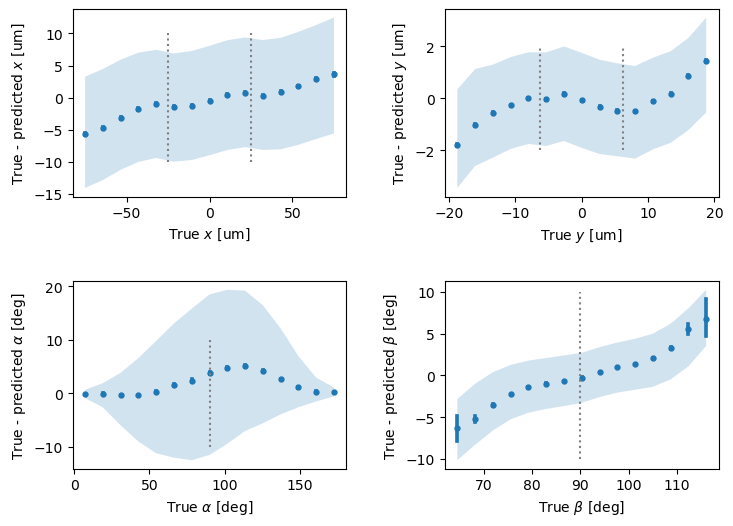

In [35]:
fig, axes = plt.subplots(2,2,figsize=(8,6))
fig.tight_layout(pad=4.0)
residual_plot(axes[0][0],df,'xtrue','x',r'$x$ [um]', scaling=75.0)
axes[0][0].plot([-25,-25],[-10,10],color='gray',linestyle=':')
axes[0][0].plot([25,25],[-10,10],color='gray',linestyle=':')
residual_plot(axes[0][1],df,'ytrue','y',r'$y$ [um]', scaling=18.75)
axes[0][1].plot([-6.25,-6.25],[-2,2],color='gray',linestyle=':')
axes[0][1].plot([6.25,6.25],[-2,2],color='gray',linestyle=':')
residual_plot_deg(axes[1][0],df,'cotAtrue','cotA',r'$\alpha$ [deg]', scaling=8.0)
axes[1][0].plot([90,90],[-10,10],color='gray',linestyle=':')
residual_plot_deg(axes[1][1],df,'cotBtrue','cotB',r'$\beta$ [deg]', scaling=0.5)
axes[1][1].plot([90,90],[-10,10],color='gray',linestyle=':')

save_fig_path = os.path.join(base_dir, 'summary.png')
plt.savefig(save_fig_path)